In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
nr_rows = 20000
df=pd.read_csv('./data/all.csv',nrows=nr_rows)
df

,Unnamed: 0,_start,_stop,_time,Area,ErrorCode,FunctionalUnit,Geohash,Line,Measurement,...,SystemIndex,ToolPosition,TypeID,WPC,WorkPosition,_measurement,Angle,PartID,TestID,Torque
0,0,1701262800000,1701266399999,1701263293436,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002437929411236351,2023-11-29T13:08:10Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
1,1,1701262800000,1701266399999,1701263311643,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002437929411243331,2023-11-29T13:08:28Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
2,2,1701262800000,1701266399999,1701263345644,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002437929411244121,2023-11-29T13:09:02Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
3,3,1701262800000,1701266399999,1701263367394,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002437929411245121,2023-11-29T13:09:24Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
4,4,1701262800000,1701266399999,1701263387177,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002437929411246271,2023-11-29T13:09:44Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,124,1702368000000,1702371599999,1702370826274,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002438012410828451,2023-12-12T08:47:03Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
19996,125,1702368000000,1702371599999,1702370856264,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002438012410829271,2023-12-12T08:47:33Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
19997,126,1702368000000,1702371599999,1702370875235,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002438011411855361,2023-12-12T08:47:52Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."
19998,127,1702368000000,1702371599999,1702370893919,99,0,2,ezjqj2by2,4104,WireCutting,...,1,1,1134240024,Def WPC,300,WireCutting,"[{""Name"":""Angle"",""Fields"":[{""Name"":""timestamp""...",113424002438012410827061,2023-12-12T08:48:10Z,"[{""Name"":""Torque"",""Fields"":[{""Name"":""timestamp..."


In [3]:
# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

In [4]:
torque_array=[]
first_rotation=[]
second_rotation=[]

for sample in range(0, nr_rows):
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"])
    torque=torque.drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    resultat = total_data[total_data['Kumulatives_Produkt'] == 1]
    resultat2 = total_data[total_data['Kumulatives_Produkt'] == 0]
    resultat2=resultat2.reset_index()

    resultat=resultat.drop(columns=["Time","Angle",'Kleiner_als_vorher',"Kumulatives_Produkt"])
    resultat2=resultat2.drop(columns=["Time","index","Angle",'Kleiner_als_vorher',"Kumulatives_Produkt"])

     # Ensure both dataframes have the same shape by truncating or padding
    max_len = 836  # Define the target length
    resultat = resultat.head(max_len).reindex(range(max_len), fill_value=0)
    resultat2 = resultat2.head(max_len).reindex(range(max_len), fill_value=0)


    first_rotation.append(resultat)
    second_rotation.append(resultat2[30:836])

    torque_array.append(torque)

In [5]:
data=np.array(first_rotation)
squeezed_arr = np.squeeze(data)

In [6]:
data2=np.array(second_rotation)
squeezed_arr2 = np.squeeze(data2)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


time = np.linspace(0, 1, 806, endpoint=False)
# Apply the low-pass filter
cutoff_frequency = 25 # Cutoff frequency in Hz
sampling_rate = 806  # Sampling rate in Hz

filtered=[]
original_signals=squeezed_arr

for signal in original_signals:
    
    # Define a low-pass filter
    def lowpass_filter(data, cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    
    filtered_signal = lowpass_filter(signal, cutoff_frequency, sampling_rate)
    filtered.append(filtered_signal)

In [14]:
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt

# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(squeezed_arr)
sz = X_train.shape[1]

seed = 0
np.random.seed(seed)
clusters=5

# kShape clustering
ks = KShape(n_clusters=clusters, verbose=True, random_state=seed,max_iter=10)
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(10, 12))  # Increase figure size for a wider plot

for yi in range(clusters):
    plt.subplot(clusters, 1, 1 + yi)
    cluster_data = X_train[y_pred == yi]
    for xx in cluster_data:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {yi + 1} - {len(cluster_data)} datasets")  # Display number of datasets

plt.tight_layout()
plt.show()

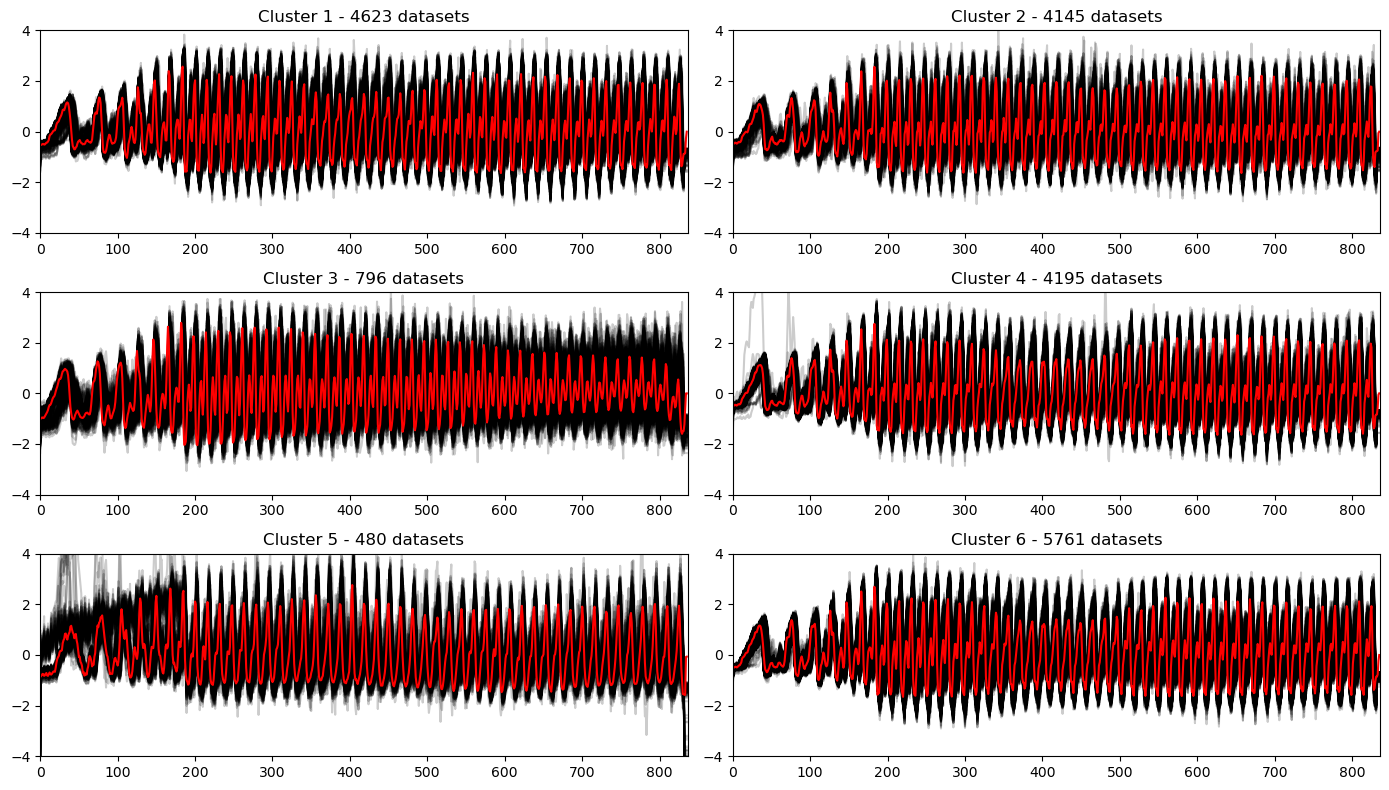

In [9]:
plt.figure(figsize=(14, 8))  # Increase figure size for a wider plot

for yi in range(clusters):
    plt.subplot(3, 2, 1 + yi)
    cluster_data = X_train[y_pred == yi]
    for xx in cluster_data:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {yi + 1} - {len(cluster_data)} datasets")  # Display number of datasets

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
from tslearn.metrics import dtw
from sklearn.cluster import DBSCAN
from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

data=np.squeeze(ks.cluster_centers_)

# Function to compute the pairwise DTW distance matrix in parallel
def compute_dtw_distance_matrix(data):
    n_series = data.shape[0]
    distance_matrix = np.zeros((n_series, n_series))

    def compute_distance(i, j):
        return dtw(data[i], data[j])

    results = Parallel(n_jobs=-1)(delayed(compute_distance)(i, j) for i in range(n_series) for j in range(i + 1, n_series))
    
    index = 0
    for i in range(n_series):
        for j in range(i + 1, n_series):
            distance = results[index]
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
            index += 1

    return distance_matrix

# Compute the DTW distance matrix
distance_matrix = compute_dtw_distance_matrix(data)


In [11]:
from sklearn.manifold import TSNE
import plotly.express as px
from tslearn.metrics import cdist_dtw


# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, metric="precomputed",init="random",perplexity=clusters-1)
tsne_results = tsne.fit_transform(distance_matrix)

# Create a DataFrame with t-SNE results and cluster labels
df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
#df['Cluster'] = clusters

# Plot the clusters using Plotly
fig = px.scatter(df, x='TSNE1', y='TSNE2', title='K-Shape Clustering with t-SNE Visualization')
fig.show()

Pairwise Distance Matrix:
[[  0.          83.78323225  83.79235783 135.43954578  71.19397851
  135.5034058 ]
 [ 83.78323225   0.         135.64093888 135.43852653  71.21256774
   83.78113492]
 [ 83.79235783 135.64093888   0.          83.81701609  71.38179201
  135.58322397]
 [135.43954578 135.43852653  83.81701609   0.          71.22159161
   83.60984144]
 [ 71.19397851  71.21256774  71.38179201  71.22159161   0.
   71.22855814]
 [135.5034058   83.78113492 135.58322397  83.60984144  71.22855814
    0.        ]]


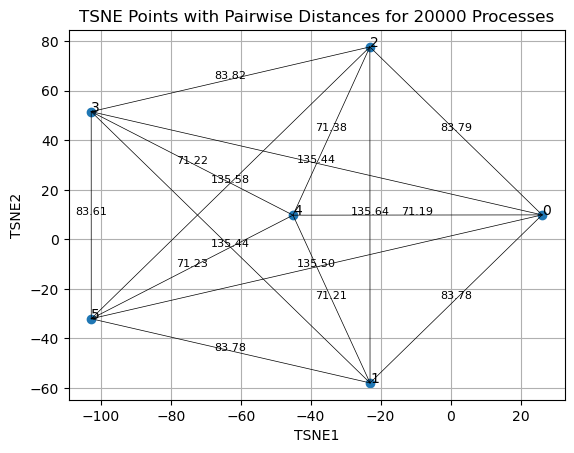

In [12]:
from scipy.spatial.distance import pdist, squareform
# Calculate pairwise distances
distances = pdist(df, metric='euclidean')
distance_matrix = squareform(distances)

# Print the distance matrix
print("Pairwise Distance Matrix:")
print(distance_matrix)

# Plot the points
plt.scatter(df['TSNE1'], df['TSNE2'])

# Annotate points with their index
for i in range(len(df)):
    plt.annotate(i, (df['TSNE1'][i], df['TSNE2'][i]))

# Draw lines between all pairs of points and label them with distances
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        x_values = [df['TSNE1'][i], df['TSNE1'][j]]
        y_values = [df['TSNE2'][i], df['TSNE2'][j]]
        plt.plot(x_values, y_values, 'k-', lw=0.5)
        mid_x = (df['TSNE1'][i] + df['TSNE1'][j]) / 2
        mid_y = (df['TSNE2'][i] + df['TSNE2'][j]) / 2
        plt.text(mid_x, mid_y, f'{distance_matrix[i][j]:.2f}', fontsize=8, ha='center')

plt.title(f'TSNE Points with Pairwise Distances for {nr_rows} Processes')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.grid(True)
plt.show()

(20000, 806)


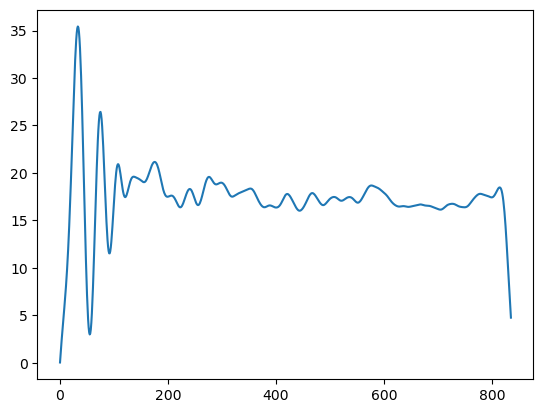

In [13]:
print(np.shape(squeezed_arr2))
plt.plot(filtered[0])
plt.show()